In [1]:
# #once per cluster
# s3helper.open_bucket('mas-dse-open',region='us-west-2')

# info_files=s3helper.ls('Weather/Info')
# Without_path=[x[13:] for x in info_files]


# !mkdir /mnt/workspace/WeatherInfo

# for i in range(len(info_files)-1):   # Last entry is the directory name
#     _from=info_files[i]
#     _to='/mnt/workspace/WeatherInfo/'+Without_path[i]
#     print('From %s to %s'%(_from,_to))
#     s3helper.s3_to_local(_from,_to)
    
# s3helper.open_bucket('dse-weather-west-2', region="us-west-2")
# s3helper.ls('')
# s3helper.s3_to_hdfs("weather.parquet", "/tmp/weather.parquet")
# s3helper.s3_to_hdfs("info/stations.parquet", "/tmp/stations.parquet")
# print(s3helper.ls_hdfs("/tmp"))

In [1]:
import os
os.getcwd()
os.chdir("/mnt/workspace/Public-DSC291/notebooks/Section2-PCA/Full_Dataset_analysis")
os.getcwd()

from Startup import *

finished standard imports
dict_items([('spark.default.parallelism', '10'), ('spark.app.name', 'Weather_PCA'), ('spark.logConf', 'True'), ('spark.executor.memory', '3g'), ('spark.cores.max', '4'), ('spark.executor.cores', '1')])
started SparkContext and SQLContext in 13.43 seconds
loaded weather.parquet in 8.25 seconds
loaded stations.parquet in 0.24 seconds
registered dataframes as tables in 0.22 seconds


In [2]:
%%time
query="""
SELECT stations.ID, stations.elevation, stations.state, stations.latitude, stations.longitude,
        weather.Station, weather.Measurement, weather.Year, weather.Values
FROM stations
LEFT JOIN weather
ON stations.ID = weather.Station
WHERE stations.state='CA' AND weather.Measurement='PRCP'
"""

print(query)
CA_weather_df=sqlContext.sql(query)
sqlContext.registerDataFrameAsTable(CA_weather_df,'CA_weather_df')


SELECT stations.ID, stations.elevation, stations.state, stations.latitude, stations.longitude,
        weather.Station, weather.Measurement, weather.Year, weather.Values
FROM stations
LEFT JOIN weather
ON stations.ID = weather.Station
WHERE stations.state='CA' AND weather.Measurement='PRCP'

CPU times: user 560 ms, sys: 72 ms, total: 632 ms
Wall time: 38.3 s


In [53]:
# print('CA has %d rows'%(CA_weather_df.count()))
# CA_weather_df.columns
# CA_weather_df.describe('latitude').show()
# CA_weather_df = CA_weather_df.filter(CA_weather_df.Year > 1960)
# CA_weather_df.show(3,truncate= True)
# CA_weather_df.select('Year', 'Values').show(3)

In [54]:
# CA_weather_df.groupby('Year').agg({'Values': 'sum'})

In [32]:
# from pyspark.sql.functions import col
# from pyspark.sql.types import DoubleType
# CA_weather_df = CA_weather_df.withColumn("Values", col("Values").cast(np.float16))

In [37]:
# CA_weather_df.groupby('Year').agg({'Values': 'mean'}).show()

In [55]:
# rdd0=CA_weather_df.rdd.map(lambda row: unpackArray(row['Values'],np.float16))
# UnDef=np.array(rdd0.map(lambda row:sum(np.isnan(row))).sample(False,0.01).collect())
# flat=rdd0.flatMap(lambda v:list(v)).filter(lambda x: not np.isnan(x)).cache()

In [56]:
CA_weather_pdf.head()

,ID,elevation,state,latitude,longitude,Station,Measurement,Year,Values
0,USC00042239,1414.3,CA,32.9897,-116.5872,USC00042239,PRCP,1899,"[0, 126, 0, 126, 12, 93, 160, 84, 0, 126, 0, 1..."
1,USC00042239,1414.3,CA,32.9897,-116.5872,USC00042239,PRCP,1900,"[0, 0, 0, 0, 132, 94, 180, 95, 0, 73, 0, 0, 0,..."
2,USC00042239,1414.3,CA,32.9897,-116.5872,USC00042239,PRCP,1901,"[0, 73, 0, 0, 0, 0, 0, 0, 0, 69, 0, 82, 80, 89..."
3,USC00042239,1414.3,CA,32.9897,-116.5872,USC00042239,PRCP,1902,"[0, 126, 0, 126, 0, 126, 0, 126, 0, 126, 0, 12..."
4,USC00042239,1414.3,CA,32.9897,-116.5872,USC00042239,PRCP,1903,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [28]:
CA_rdd = CA_weather_df.rdd.map(list)

In [22]:
rdd0 = CA_weather_df.rdd.map(lambda row: unpackArray(row['Values'],np.float16))
rdd0 = rdd0.map(lambda row: np.nan_to_num(row))

In [32]:
rddAnom = rdd0.map(lambda row: np.sum(row))

In [34]:
rddAnom.take(3)

[32928.0, 4568.0, 6032.0]

In [3]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

my_udf = F.UserDefinedFunction(lambda row: float(np.nanmean(unpackArray(row,np.float16))),
                               T.DoubleType())
CA_weather_df = CA_weather_df.withColumn('Values_sum', my_udf('Values'))
CA_weather_df.show(10)

+-----------+---------+-----+--------+---------+-----------+-----------+----+--------------------+----------+
|         ID|elevation|state|latitude|longitude|    Station|Measurement|Year|              Values|Values_sum|
+-----------+---------+-----+--------+---------+-----------+-----------+----+--------------------+----------+
|USC00042239|   1414.3|   CA| 32.9897|-116.5872|USC00042239|       PRCP|1899|[00 7E 00 7E 0C 5...|   128.125|
|USC00042239|   1414.3|   CA| 32.9897|-116.5872|USC00042239|       PRCP|1900|[00 00 00 00 84 5...| 21.140625|
|USC00042239|   1414.3|   CA| 32.9897|-116.5872|USC00042239|       PRCP|1901|[00 49 00 00 00 0...|   80.4375|
|USC00042239|   1414.3|   CA| 32.9897|-116.5872|USC00042239|       PRCP|1902|[00 7E 00 7E 00 7...| 25.421875|
|USC00042239|   1414.3|   CA| 32.9897|-116.5872|USC00042239|       PRCP|1903|[00 00 00 00 00 0...| 23.890625|
|USC00042239|   1414.3|   CA| 32.9897|-116.5872|USC00042239|       PRCP|1904|[00 00 00 00 00 0...| 27.984375|
|USC000422

In [4]:
avg = CA_weather_df.groupby('Station').agg({'Values_sum': 'mean'})

In [7]:
avg.show()

+-----------+------------------+
|    Station|   avg(Values_sum)|
+-----------+------------------+
|USC00040174|2.0240885416666665|
|USC00044056| 20.51215277777778|
|US1CARV0008| 8.589762369791666|
|USC00043405| 43.01081730769231|
|USC00047965|23.466517857142858|
|US1CASN0094|25.145833333333332|
|USC00046390| 2.822975852272727|
|US1CASR0004|   13.260986328125|
|US1CASZ0015|           242.875|
|USC00045371|       10.68359375|
|USC00043735|       16.41640625|
|US1CASC0018|        9.81484375|
|USC00045032|12.423014322916666|
|USC00046599|       25.55390625|
|USS0020K13S|29.976792279411764|
|USC00042218| 47.84829545454546|
|USC00046154|   5.4309814453125|
|US1CAOR0020|         32.734375|
|USW00023226|     18.6142578125|
|US1CASM0008|       11.17890625|
+-----------+------------------+
only showing top 20 rows



In [5]:
a = CA_weather_df.alias('a')
b = avg.alias('b')
CA_weather_df = a.join(b, "Station")

In [8]:
CA_weather_df = CA_weather_df.drop('Values', 'ID')

In [9]:
CA_weather_df.show()

+-----------+---------+-----+--------+---------+-----------+----+-------------+------------------+
|    Station|elevation|state|latitude|longitude|Measurement|Year|   Values_sum|   avg(Values_sum)|
+-----------+---------+-----+--------+---------+-----------+----+-------------+------------------+
|US1CARV0008|    427.9|   CA| 33.7307|-117.4276|       PRCP|2008|    9.8046875| 8.589762369791666|
|US1CARV0008|    427.9|   CA| 33.7307|-117.4276|       PRCP|2009|   6.16015625| 8.589762369791666|
|US1CARV0008|    427.9|   CA| 33.7307|-117.4276|       PRCP|2010|        20.75| 8.589762369791666|
|US1CARV0008|    427.9|   CA| 33.7307|-117.4276|       PRCP|2011|    8.0546875| 8.589762369791666|
|US1CARV0008|    427.9|   CA| 33.7307|-117.4276|       PRCP|2012|    6.0546875| 8.589762369791666|
|US1CARV0008|    427.9|   CA| 33.7307|-117.4276|       PRCP|2013|0.71435546875| 8.589762369791666|
|US1CASN0094|     66.4|   CA|  38.324|-123.0304|       PRCP|2011|     19.53125|25.145833333333332|
|US1CASN00

In [12]:
CA_weather_df = CA_weather_df.withColumn('Anom', F.col('Values_sum')-F.col('avg(Values_sum)'))

In [13]:
CA_weather_df.show()

+-----------+---------+-----+--------+---------+-----------+----+-------------+------------------+-------------------+
|    Station|elevation|state|latitude|longitude|Measurement|Year|   Values_sum|   avg(Values_sum)|               Anom|
+-----------+---------+-----+--------+---------+-----------+----+-------------+------------------+-------------------+
|US1CARV0008|    427.9|   CA| 33.7307|-117.4276|       PRCP|2008|    9.8046875| 8.589762369791666|  1.214925130208334|
|US1CARV0008|    427.9|   CA| 33.7307|-117.4276|       PRCP|2009|   6.16015625| 8.589762369791666| -2.429606119791666|
|US1CARV0008|    427.9|   CA| 33.7307|-117.4276|       PRCP|2010|        20.75| 8.589762369791666| 12.160237630208334|
|US1CARV0008|    427.9|   CA| 33.7307|-117.4276|       PRCP|2011|    8.0546875| 8.589762369791666|-0.5350748697916661|
|US1CARV0008|    427.9|   CA| 33.7307|-117.4276|       PRCP|2012|    6.0546875| 8.589762369791666| -2.535074869791666|
|US1CARV0008|    427.9|   CA| 33.7307|-117.4276|

In [22]:
pd1stat = CA_weather_df.filter(CA_weather_df["Station"] == 'USC00040174').toPandas()

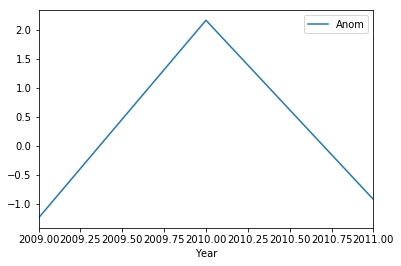

In [23]:
import matplotlib.pyplot as plt
pd1stat.plot.line('Year', 'Anom')
plt.show()